In [185]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from matplotlib import pyplot as plt

# More detailed documentation can be found here
#        https://mimic.mit.edu/docs/iii/tables/
# For simplicity, we are only loading 
#        admissions - data from admission of a patient, links to patients on subject_id
#        patients   - data defining a patient
df_admin = pd.read_csv('data/ADMISSIONS.csv')
df_patients = pd.read_csv('data/PATIENTS.csv')

#column names to lowercase
df_admin.columns = df_admin.columns.str.lower()
df_patients.columns = df_patients.columns.str.lower()

#drop columns to simplify for first analysis
df_admin = df_admin.drop(columns=['row_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
                                 'admission_type', 'admission_location', 'discharge_location', 
                                 'edregtime', 'edouttime', 'diagnosis', 'has_chartevents_data'])
df_patients = df_patients.drop(columns=['row_id', 'dod_ssn'])
df = pd.merge(df_admin, df_patients, on="subject_id") 

#print("Admissions:\n",df_admin.count(),"\n")
#print("Patients:\n", df_patients.count(),"\n")
#print("Merged:\n", df.count())


In [195]:
#df.subject_id.isna()
#len(df.subject_id.unique())
print(len(df))
df.head()
#df.describe()

58976


,subject_id,insurance,language,religion,marital_status,ethnicity,hospital_expire_flag,gender,dob,dod,dod_hosp,expire_flag
0,22,Private,UNKNOWN,UNKNOWN,MARRIED,WHITE,0,F,2131-05-07 00:00:00,NaN,NaN,0
1,23,Medicare,UNKNOWN,CHRISTIAN,MARRIED,WHITE,0,M,2082-07-17 00:00:00,NaN,NaN,0
2,23,Medicare,ENGL,CHRISTIAN,MARRIED,WHITE,0,M,2082-07-17 00:00:00,NaN,NaN,0
3,24,Private,UNKNOWN,CHRISTIAN,SINGLE,WHITE,0,M,2100-05-31 00:00:00,NaN,NaN,0
4,25,Private,UNKNOWN,UNKNOWN,MARRIED,WHITE,0,M,2101-11-21 00:00:00,NaN,NaN,0


In [196]:
#data cleanup and grouping

df['ethnicity'] = list(map(lambda s: re.sub("UNKNOWN.*|UNABLE.*|PATIENT.*", "OTHER", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("WHITE.*|PORTUGUESE.*", "WHITE", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("ASIAN.*", "ASIAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("BLACK.*", "BLACK", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("HISPANIC.*|AMERICAN.*", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("CARIBBEAN.*|HAWAIIAN.*", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub(".*AMERICAN", "AMERICAN", s), df['ethnicity']))
df['ethnicity'] = list(map(lambda s: re.sub("MULTI.*", "MULTI RACE", s), df['ethnicity']))

df['marital_status'] = df['marital_status'].fillna('UNKNOWN')
df['marital_status'] = list(map(lambda s: re.sub("UNKNOWN.*", "UNKNOWN", s), df['marital_status']))

df['religion'] = df['religion'].fillna('UNKNOWN')
df['religion'] = list(map(lambda s: re.sub("NOT.*|UN.*|OTHER", "UNKNOWN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("PROT.*|LUTH.*|METHO.*|BAPT.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub(".*ORTH.*|.*ADVEN.*|CHRIST.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("EPISCO.*|CATHOLIC|JEHOV.*", "CHRISTIAN", s), df['religion']))
df['religion'] = list(map(lambda s: re.sub("HEBREW", "JEWISH", s), df['religion']))

df['language'] = df['language'].fillna('UNKNOWN')
df['language'] = list(map(lambda s: re.sub("\*.*", "OTHER", s), df['language']))
lan_counts = df['language'].value_counts() > 700
df['language'] = list(map(lambda s: s if lan_counts[s] else "OTHER", df['language']))

#print(df['language'].value_counts())
#print(df['language'].unique())


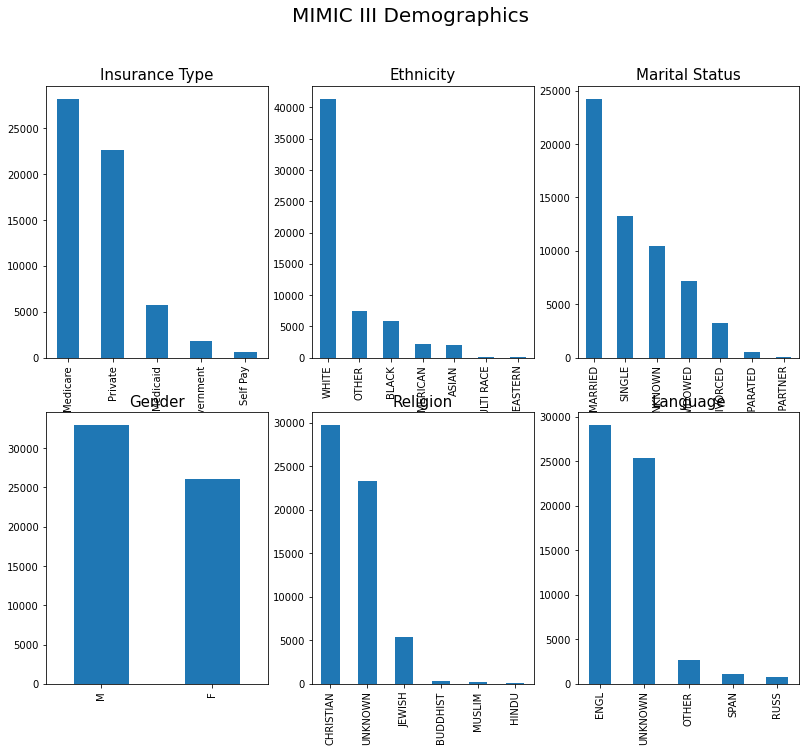

In [215]:
fig = plt.figure()
fig.suptitle('MIMIC III Demographics', fontsize=20)
plt.rcParams["figure.figsize"] = (13.5, 11)
ax1 = fig.add_subplot(2,3,1)
ax1 = df['insurance'].value_counts().plot(kind='bar')
ax1.set_title('Insurance Type', fontsize = 15)
ax2 = fig.add_subplot(2,3,2)
ax2 = df['ethnicity'].value_counts().plot(kind='bar')
ax2.set_title('Ethnicity', fontsize = 15)
ax3 = fig.add_subplot(2,3,3)
ax3 = df['marital_status'].value_counts().plot(kind='bar')
ax3.set_title('Marital Status', fontsize = 15)
ax4 = fig.add_subplot(2,3,4)
ax4 = df['gender'].value_counts().plot(kind='bar')
ax4.set_title('Gender', fontsize = 15)
ax5 = fig.add_subplot(2,3,5)
ax5 = df['religion'].value_counts().plot(kind='bar')
ax5.set_title('Religion', fontsize = 15)
ax5 = fig.add_subplot(2,3,6)
ax5 = df['language'].value_counts().plot(kind='bar')
ax5.set_title('Language', fontsize = 15)
plt.show()

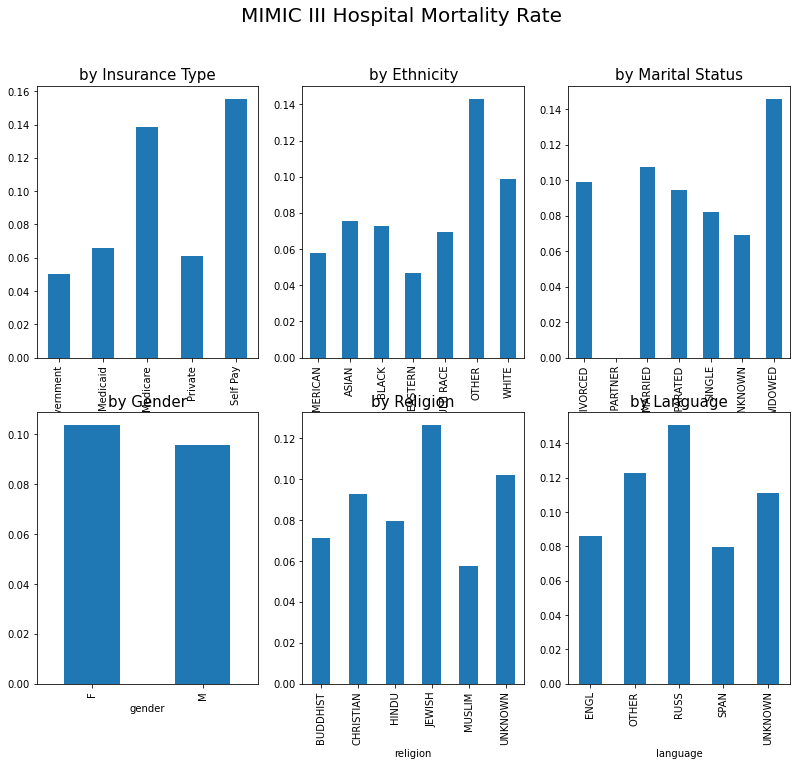

In [219]:
fig = plt.figure()
fig.suptitle('MIMIC III Hospital Mortality Rate', fontsize=20)
plt.rcParams["figure.figsize"] = (13.5, 11)
ax1 = fig.add_subplot(2,3,1)
ax1 = df.groupby('insurance').hospital_expire_flag.mean().plot(kind='bar')
ax1.set_title('by Insurance Type', fontsize = 15)
ax2 = fig.add_subplot(2,3,2)
ax2 = df.groupby('ethnicity').hospital_expire_flag.mean().plot(kind='bar')
ax2.set_title('by Ethnicity', fontsize = 15)
ax3 = fig.add_subplot(2,3,3)
ax3 = df.groupby('marital_status').hospital_expire_flag.mean().plot(kind='bar')
ax3.set_title('by Marital Status', fontsize = 15)
ax4 = fig.add_subplot(2,3,4)
ax4 = df.groupby('gender').hospital_expire_flag.mean().plot(kind='bar')
ax4.set_title('by Gender', fontsize = 15)
ax5 = fig.add_subplot(2,3,5)
ax5 = df.groupby('religion').hospital_expire_flag.mean().plot(kind='bar')
ax5.set_title('by Religion', fontsize = 15)
ax5 = fig.add_subplot(2,3,6)
ax5 = df.groupby('language').hospital_expire_flag.mean().plot(kind='bar')
ax5.set_title('by Language', fontsize = 15)
plt.show()

In [201]:
#for label, data in group:
#    print(label)
#    print('-'*70)
#    print(data)
#    print('\n')
#group.size()

group = df.groupby('insurance')
print(group.hospital_expire_flag.mean())

group = df.groupby('ethnicity')
print(group.hospital_expire_flag.mean())

group = df.groupby('marital_status')
print(group.hospital_expire_flag.mean())

group = df.groupby('gender')
print(group.hospital_expire_flag.mean())

group = df.groupby('religion')
print(group.hospital_expire_flag.mean())

group = df.groupby('language')
print(group.hospital_expire_flag.mean())


insurance
Government    0.050477
Medicaid      0.065860
Medicare      0.138402
Private       0.061243
Self Pay      0.155483
Name: hospital_expire_flag, dtype: float64
ethnicity
AMERICAN          0.057736
ASIAN             0.075735
BLACK             0.072774
MIDDLE EASTERN    0.046512
MULTI RACE        0.069231
OTHER             0.143089
WHITE             0.098632
Name: hospital_expire_flag, dtype: float64
marital_status
DIVORCED        0.099284
LIFE PARTNER    0.000000
MARRIED         0.107678
SEPARATED       0.094571
SINGLE          0.082390
UNKNOWN         0.069321
WIDOWED         0.146027
Name: hospital_expire_flag, dtype: float64
gender
F    0.103742
M    0.095721
Name: hospital_expire_flag, dtype: float64
religion
BUDDHIST     0.071161
CHRISTIAN    0.092734
HINDU        0.079646
JEWISH       0.126454
MUSLIM       0.057778
UNKNOWN      0.102189
Name: hospital_expire_flag, dtype: float64
language
ENGL       0.086158
OTHER      0.122905
RUSS       0.150633
SPAN       0.079409
UNKNOW

In [14]:
#correlation matrix
#correlation_matrix = df.corr(method='pearson')
#sns.heatmap(correlation_matrix, vmax=1.0, vmin=-1.0,square=True, cmap='viridis')
#correlation_matrix

#stats.f_oneway(sepal_len_setosa, sepal_len_vers, sepal_len_virg)